# CLG Step 3: Network Construction & Analysis

This notebook processes the calibrated single-neuron traces to construct functional connectivity networks and analyze their topology.

**Workflow:**
1.  **Load Data**: Import the calibrated traces from Step 2.
2.  **Preprocessing**:
    *   **Denoising (PCA)**: Use Principal Component Analysis to reconstruct traces and reduce noise.
    *   **dF/F Calculation**: Compute relative fluorescence changes.
3.  **Network Construction**:
    *   Compute Pairwise Pearson Correlation Matrix.
    *   Define Edges based on a high correlation threshold (e.g., > 0.95).
4.  **Network Analysis**:
    *   Compute topological metrics: **Degree**, **Eigenvector Centrality**, **Clustering Coefficient**.
    *   Compare distributions.
5.  **Visualization**: Plot metric distributions.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import eigsh  
import networkx as nx
from joblib import Parallel, delayed
from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_size(32)  

try:
    import dff
    HAS_ALLEN = True
except ImportError:
    raise SystemExit("AllenSDK not found. Aborting execution.")

from scipy import io as sio

OUTPUT_DIR = r'/home/jjzhao/GDM/xinceshi/ptz_3'
INPUT_FILE = os.path.join(OUTPUT_DIR, 'CellTrace_after_calibration.mat')
PCA_VARIANCE_THRESHOLD = 0.95
CORRELATION_THRESHOLD = 0.95
SAMPLING_RATE = 1.0 

print(f"Loading data from: {INPUT_FILE}")

Loading data from: /home/jjzhao/GDM/xinceshi/ptz_3/CellTrace_after_calibration.mat


## 1. Load Calibrated Data

In [2]:
data = sio.loadmat(INPUT_FILE)


if 'trace' in data:
    traces = data['trace']  
elif 'traces' in data:
    traces = data['traces']
else:
    raise KeyError(f"Could not find 'trace' or 'traces' in {INPUT_FILE}. Available keys: {list(data.keys())}")

if 'pos' in data:
    positions = data['pos']  
elif 'positions' in data:
    positions = data['positions']
else:
    raise KeyError(f"Could not find 'pos' or 'positions' in {INPUT_FILE}. Available keys: {list(data.keys())}")

if 'nucIndex' in data:
    ids = data['nucIndex'].flatten()  
elif 'ids' in data:
    ids = data['ids'].flatten()
else:
   
    ids = np.arange(traces.shape[0])
    print("Warning: No 'nucIndex' or 'ids' found. Creating sequential IDs.")

print(f"Loaded {traces.shape[0]} neurons with {traces.shape[1]} timepoints.")


valid_mask = np.any(traces != 0, axis=1)
traces = traces[valid_mask]
positions = positions[valid_mask]
ids = ids[valid_mask]

print(f"After cleaning zeros: {traces.shape[0]} neurons remain.")

Loaded 39038 neurons with 599 timepoints.
After cleaning zeros: 39038 neurons remain.


## 2. Preprocessing: dF/F & PCA Denoising

In [3]:
def compute_dff_Allen(traces, fs):
  
    if not HAS_ALLEN:
        return (traces - np.mean(traces, axis=1, keepdims=True)) / (np.mean(traces, axis=1, keepdims=True) + 1e-6)
    
    index_long = int(300 * fs // 2 * 2 + 1)
    index_short = int((10/3) * fs // 2 * 2 + 1)

    traces_dff = dff.compute_dff_windowed_median(traces,
                                                 median_kernel_long=index_long,
                                                 median_kernel_short=index_short)
    
    return traces_dff

def compute_dff_Allen_parallel(traces, fs, n_jobs=30, batch_size=6):
   
    if not HAS_ALLEN:
        return compute_dff_Allen(traces, fs)
    
    ROI_num = traces.shape[0]
    traces_dff = Parallel(n_jobs=n_jobs)(
        delayed(compute_dff_Allen)(traces[i:min(i+batch_size, ROI_num), :], fs) 
        for i in range(0, ROI_num, batch_size)
    )
    traces_dff = np.concatenate(traces_dff, axis=0)
    return traces_dff

def pca_reconstruction(data, variance_threshold=0.95, standardize=False):

    
    if standardize:
        scaler = StandardScaler()
        data_processed = scaler.fit_transform(data)
    else:
        scaler = None
        data_processed = data.copy()

    pca = PCA(n_components=variance_threshold, svd_solver='full')
    pca.fit(data_processed)
    
    print(f"保留方差比例: {variance_threshold*100}%")
    print(f"选择主成分数量: {pca.n_components_}")
    print(f"累计解释方差: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")

    reconstructed_processed = pca.inverse_transform(pca.transform(data_processed))
    
    if standardize:
        reconstructed = scaler.inverse_transform(reconstructed_processed)
    else:
        reconstructed = reconstructed_processed

    return reconstructed, pca, scaler

print("Computing dF/F...")
traces_dff = compute_dff_Allen_parallel(traces, SAMPLING_RATE, n_jobs=30, batch_size=6)
print("dF/F calculation complete.")

print("Running PCA Denoising...")
traces_denoised, pca_model, scaler = pca_reconstruction(traces_dff, PCA_VARIANCE_THRESHOLD, standardize=False)
print("PCA reconstruction complete.")

Computing dF/F...


dF/F calculation complete.
Running PCA Denoising...
保留方差比例: 95.0%
选择主成分数量: 28
累计解释方差: 95.11%
PCA reconstruction complete.


## 3. Network Construction
Compute the correlation matrix and define the graph.

In [4]:
print("Computing Correlation Matrix...")
corr_matrix = squareform(pdist(traces_denoised, "correlation"))
corr_matrix = 1 - corr_matrix

indices = np.diag_indices(corr_matrix.shape[0])
corr_matrix[indices] = 0

print(f"Correlation matrix computed: shape {corr_matrix.shape}")

def create_network(adj_matrix, indexs, threshold=0.95):

    G = nx.Graph()
    n = adj_matrix.shape[0]
    
    for i in range(n):
        G.add_node(i, ind=indexs[i])
    
    for i in range(n):
        for j in range(i+1, n):
            if abs(adj_matrix[i, j]) > threshold:
                G.add_edge(i, j)
    
    return G

print(f"Building Graph with Threshold > {CORRELATION_THRESHOLD}...")
G = create_network(corr_matrix, ids, threshold=CORRELATION_THRESHOLD)
print(f"Graph constructed: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges (full graph).")

Computing Correlation Matrix...
Correlation matrix computed: shape (39038, 39038)
Building Graph with Threshold > 0.95...
Graph constructed: 39038 nodes, 2238093 edges (full graph).


## 4. Network Metrics & Analysis
Calculate Degree, Eigenvector Centrality, etc.

In [5]:
def calculate_metrics(graph):
    
    print('\nDegree:')
    degree = dict(graph.degree())
    metrics = {
        'degree': degree,
    }
    return metrics

print("Calculating Network Metrics...")

metrics = calculate_metrics(G)
degrees = metrics['degree']
degree_values = list(degrees.values())

print(f"Degree calculation complete. Mean degree: {np.mean(degree_values):.2f}")


Calculating Network Metrics...

Degree:
Degree calculation complete. Mean degree: 114.66


In [6]:

print("Calculating Eigenvector Centrality using eigsh on full graph...")


try:
    eigenvalues, eigenvectors = eigsh(np.abs(corr_matrix.astype('float32')), 
                                      k=1, which='LM')

    eigenvector_centrality = np.abs(eigenvectors[:, 0])
    eigenvector_centrality /= np.linalg.norm(eigenvector_centrality, ord=1)  
    

    eigen_centrality_dict = {i: eigenvector_centrality[i] 
                             for i in range(len(eigenvector_centrality))}
    eigen_values = list(eigenvector_centrality)
    
    print(f"Eigenvector centrality calculation complete. Mean: {np.mean(eigen_values):.6f}")
except Exception as e:
    print(f"Eigenvector centrality calculation failed: {e}")
    eigen_centrality_dict = {}
    eigen_values = []

print("Metrics calculation complete.")

Calculating Eigenvector Centrality using eigsh on full graph...


Eigenvector centrality calculation complete. Mean: 0.000026
Metrics calculation complete.


## 5. Visualization
Plot the Degree Distribution.

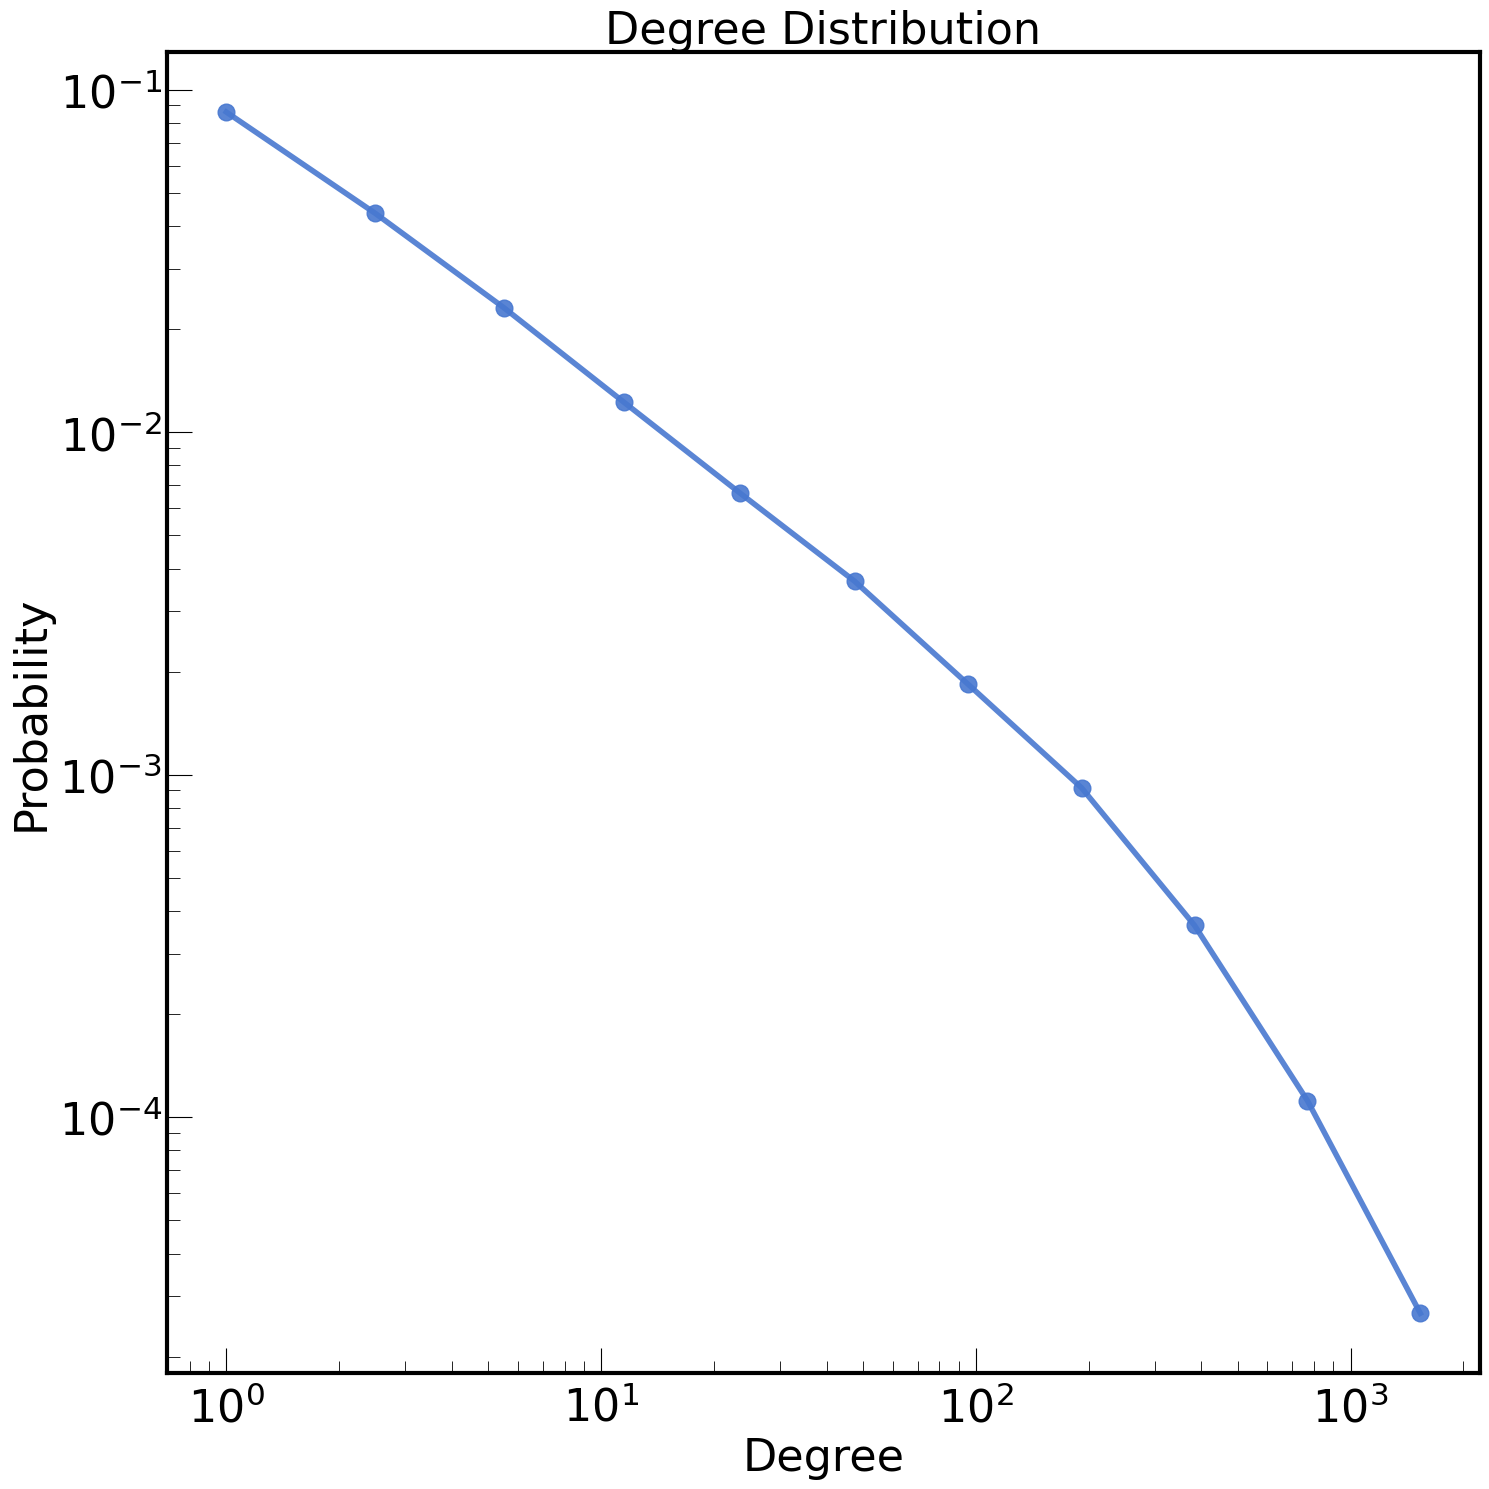

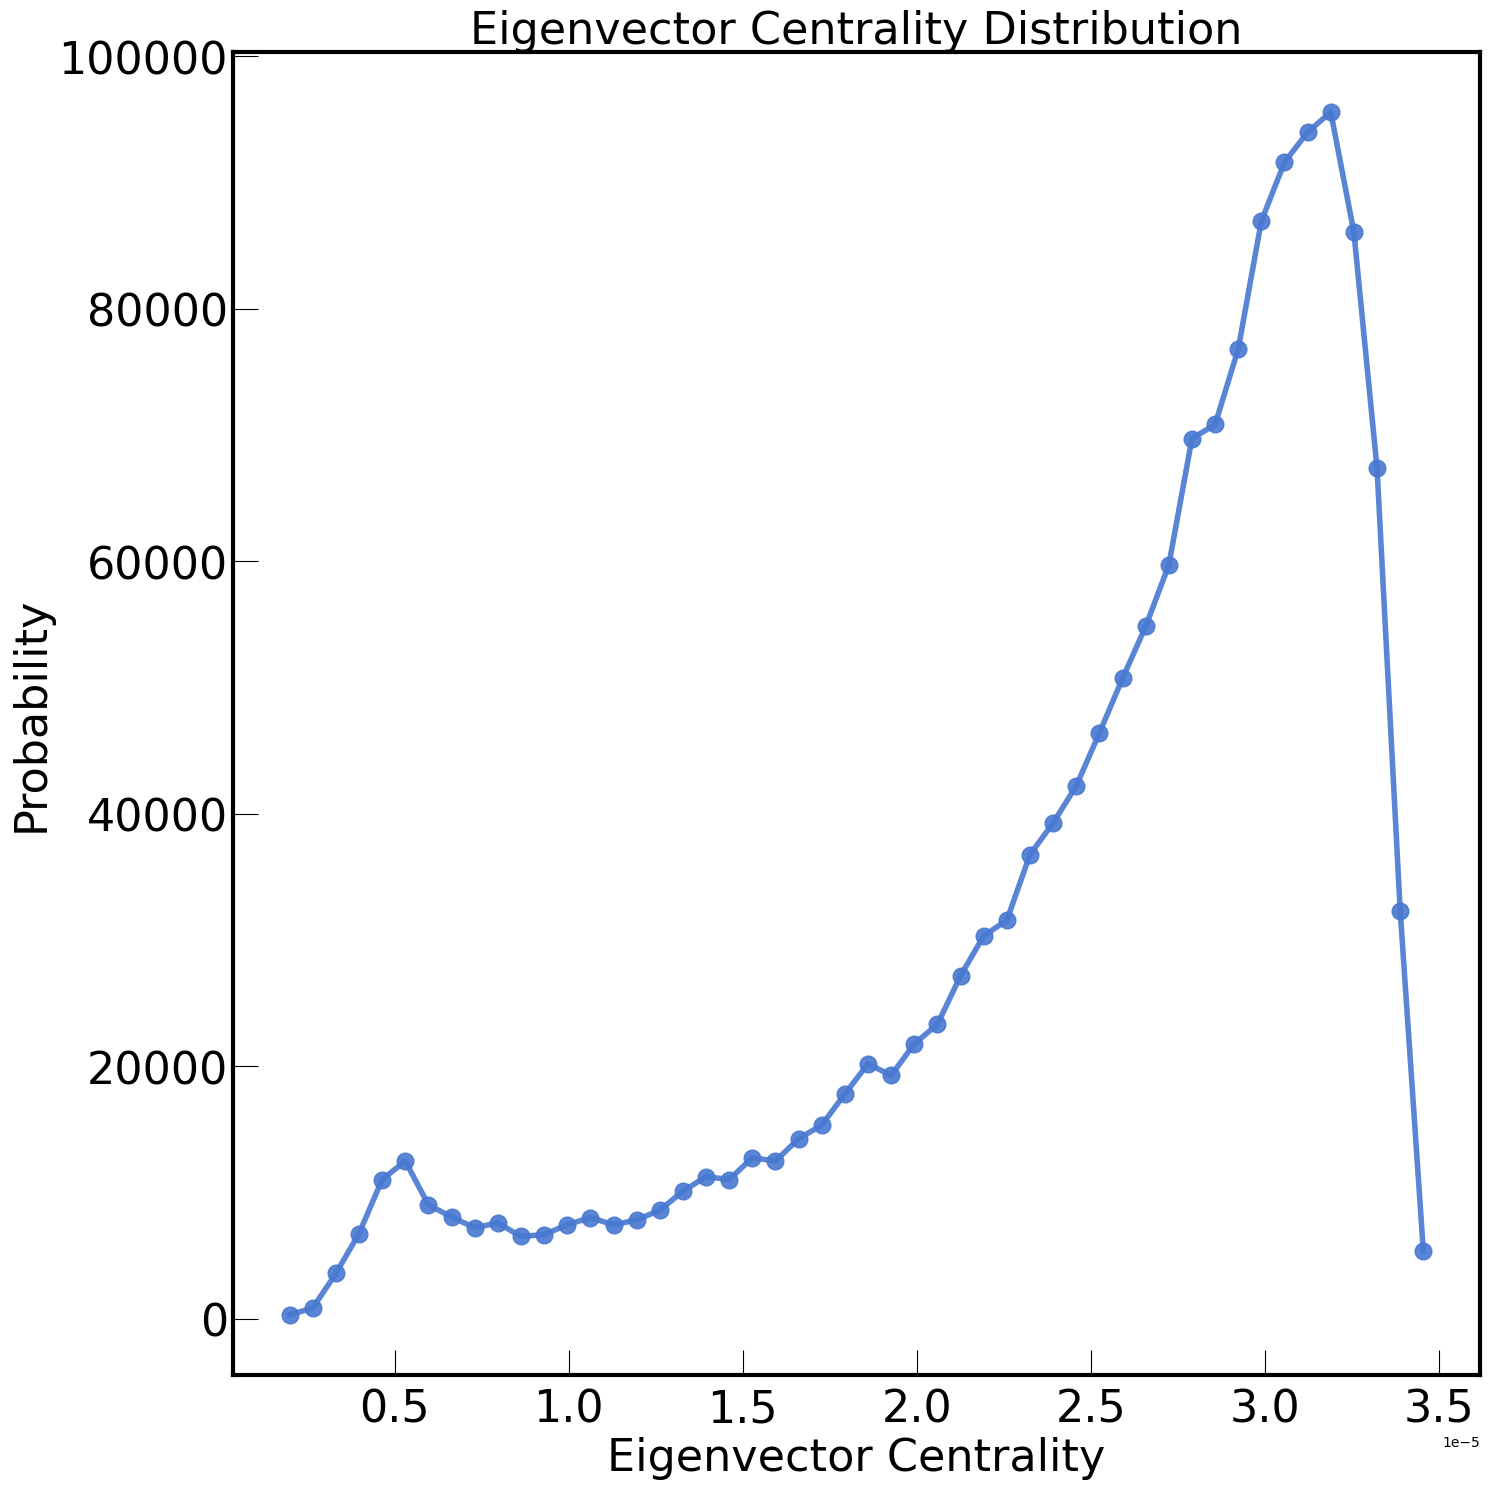

In [7]:

def plot_metric_hist(metric_values, metric_name='Degree', title=None, use_log_scale=True):

    fig, ax = plt.subplots(figsize=(15, 15))
    cmName = 'muted'
    

    if use_log_scale:

        bins = np.logspace(0, 14, 15, base=2) - 0.5
    else:

        bins = 50
    

    hist, bins = np.histogram(metric_values, 
                              bins=bins, 
                              density=True)
    x = (bins[:-1] + bins[1:]) / 2

    mask = hist > 0
    plt.plot(x[mask], hist[mask],
             marker='o',
             markersize=12,
             color=sns.color_palette(cmName)[0],
             linewidth=4,
             linestyle='-',
             alpha=0.9)
    
    if title is None:
        title = f'{metric_name} Distribution'
    plt.title(title, fontproperties=font)
    

    if use_log_scale:
        ax.set_yscale('log')
        ax.set_xscale('log')
    else:
        ax.set_yscale('linear')
        ax.set_xscale('linear')

    
    ax.set_xlabel(metric_name, fontproperties=font)
    ax.set_ylabel('Probability', fontproperties=font)
    
    plt.tick_params(axis='x', which='major', direction='in', length=18, labelsize=32, pad=9)
    plt.tick_params(axis='x', which='minor', direction='in', length=9)
    plt.tick_params(axis='y', which='major', direction='in', length=18, labelsize=32)
    plt.tick_params(axis='y', which='minor', direction='in', length=9)
    
    ax.spines['left'].set_linewidth(3)   
    ax.spines['bottom'].set_linewidth(3) 
    ax.spines['right'].set_linewidth(3)  
    ax.spines['top'].set_linewidth(3)    
    
    plt.tight_layout()
    return fig, ax


plot_metric_hist(degree_values, metric_name='Degree', title='Degree Distribution', use_log_scale=True)
plt.show()


if eigen_values:
    plot_metric_hist(eigen_values, metric_name='Eigenvector Centrality', 
                     title='Eigenvector Centrality Distribution', use_log_scale=False)
    plt.show()